<a href="https://colab.research.google.com/github/Kevin-J-Mathew/Python-Projects/blob/main/IDC_Prediction_using_WSI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**DOWNLOADING LIBRARIES**

In [ ]:
!pip install openslide-python opencv-python-headless tqdm
!pip install openslide-bin

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 48.8 MB/s eta 0:00:00


In [ ]:
!pip install git+https://github.com/EIDOSLAB/torchstain.git

  Cloning https://github.com/EIDOSLAB/torchstain.git to /tmp/pip-req-build-ilqbkdj9
  Running command git clone --filter=blob:none --quiet https://github.com/EIDOSLAB/torchstain.git /tmp/pip-req-build-ilqbkdj9
  Resolved https://github.com/EIDOSLAB/torchstain.git to commit 3e10af2299998fe9e2e3e5072294bc08ffebb6c1
  Preparing metadata (setup.py) ... done
  Created wheel for torchstain: filename=torchstain-1.4.1-py3-none-any.whl size=37810 sha256=1b672ff3441c1dd70f36bc6a998ffbdf202210af613c3da8dc87f3f171655611
  Stored in directory: /tmp/pip-ephem-wheel-cache-39i7xjfp/wheels/80/45/9c/e195ad295308d66b6e041b9989bfcfcfb19b886a26755e8bb8
Successfully built torchstain


In [ ]:
!pip install openslide-python staintools opencv-python-headless tqdm

  Preparing metadata (setup.py) ... done
  Created wheel for staintools: filename=staintools-2.1.2-py3-none-any.whl size=14049 sha256=dd940bd4d27cb66973a54d42e054038e17f2722934e978ad2aabe39ae89c678d
  Stored in directory: /root/.cache/pip/wheels/0c/c4/69/fc8068103fe40879db0187cd442d181b1e741e849f33814600
Successfully built staintools


In [ ]:
!pip install timm --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 65.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.5 MB/s eta 0:00:00


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [ ]:
import zipfile
import random
import os
import torch
import seaborn as sns
import openslide
import matplotlib.pyplot as plt
import cv2
import timm
import pandas as pd
import gc
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torch.optim as optim
import glob
import numpy as np
import shutil
from sklearn.model_selection import StratifiedKFold
from torchvision.models import resnet50
from skimage.color import rgb2hsv
from sklearn.feature_extraction import image as sk_image
from PIL import Image
from PIL import Image, ImageEnhance, ImageOps
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
from tqdm import tqdm
from pathlib import Path
from torchvision import transforms
from PIL import Image, ImageEnhance, ImageOps, ImageFilter
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset

**LOADING THE DATA**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
zip_path = '/content/drive/MyDrive/IDC DATA.zip'
extract_path = '/content/IDC_DATA'

# Unzip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Unzipped successfully!")


✅ Unzipped successfully!


**STAIN NORMALIZATION AND PATCH EXTRACTION**

In [ ]:
ROOT_DIR = "/content/IDC_DATA/IDC DATA"  # Has "yes" and "no" folders
PATCH_DIR = "/content/patches_normalised"
PATCH_SIZE = 256
PATCHES_PER_SLIDE = 300
LEVEL = 0
MAX_TRIES = PATCHES_PER_SLIDE * 15

# Utility to filter white/empty patches
def is_tissue(patch, white_thresh=0.85):
    gray = cv2.cvtColor(patch, cv2.COLOR_RGB2GRAY)
    return (np.mean(gray > 220) < white_thresh)

# Simple contrast-based normalization
def normalize_patch(patch):
    norm = np.zeros_like(patch)
    for c in range(3):
        p = patch[:, :, c]
        p2 = np.percentile(p, (1, 99))
        norm[:, :, c] = np.clip((p - p2[0]) * 255.0 / (p2[1] - p2[0] + 1e-5), 0, 255)
    return norm.astype(np.uint8)

# Loop through class folders: "yes" and "no"
for class_label in ["Yes", "No"]:
    class_path = os.path.join(ROOT_DIR, class_label)
    slide_files = [f for f in os.listdir(class_path) if f.endswith(".svs")]
    print(f"🔍 Found {len(slide_files)} slides in '{class_label}' folder")

    for svs_file in tqdm(slide_files, desc=f"Processing {class_label} slides"):
        slide_path = os.path.join(class_path, svs_file)
        slide_id = os.path.splitext(svs_file)[0]
        out_dir = os.path.join(PATCH_DIR, class_label, slide_id)
        os.makedirs(out_dir, exist_ok=True)

        try:
            slide = openslide.OpenSlide(slide_path)
            w, h = slide.level_dimensions[LEVEL]
            count = 0
            tries = 0
            while count < PATCHES_PER_SLIDE and tries < MAX_TRIES:
                x = random.randint(0, w - PATCH_SIZE)
                y = random.randint(0, h - PATCH_SIZE)
                img = slide.read_region((x, y), LEVEL, (PATCH_SIZE, PATCH_SIZE)).convert("RGB")
                patch = np.array(img)
                if is_tissue(patch):
                    patch = normalize_patch(patch)
                    Image.fromarray(patch).save(os.path.join(out_dir, f"patch_{count:04d}.png"))
                    count += 1
                tries += 1
            slide.close()
            print(f"✅ {slide_id}: {count} patches saved to {out_dir}")
        except Exception as e:
            print(f"❌ Error processing {svs_file}: {str(e)}")

print("✅ All patch extraction complete. Saved under:", PATCH_DIR)

🔍 Found 15 slides in 'Yes' folder


Processing Yes slides:   7%|▋         | 1/15 [00:13<03:03, 13.13s/it]

✅ TCGA-A8-A06Q-01Z-00-DX1.622AC6E4-DB1A-4C8D-8185-52D4FD1F30B4: 300 patches saved to /content/patches_normalised/Yes/TCGA-A8-A06Q-01Z-00-DX1.622AC6E4-DB1A-4C8D-8185-52D4FD1F30B4


Processing Yes slides:  13%|█▎        | 2/15 [00:33<03:44, 17.29s/it]

✅ TCGA-A8-A095-01Z-00-DX1.97072E53-7323-4836-9D58-22B7C346A7CE: 300 patches saved to /content/patches_normalised/Yes/TCGA-A8-A095-01Z-00-DX1.97072E53-7323-4836-9D58-22B7C346A7CE


Processing Yes slides:  20%|██        | 3/15 [00:58<04:10, 20.86s/it]

✅ TCGA-A7-A0CD-01Z-00-DX2.609CED8D-5947-4753-A75B-73A8343B47EC: 266 patches saved to /content/patches_normalised/Yes/TCGA-A7-A0CD-01Z-00-DX2.609CED8D-5947-4753-A75B-73A8343B47EC


Processing Yes slides:  27%|██▋       | 4/15 [01:12<03:20, 18.24s/it]

✅ TCGA-A8-A08F-01Z-00-DX1.9D2222F6-1425-46FD-BC94-728EF835FAC2: 300 patches saved to /content/patches_normalised/Yes/TCGA-A8-A08F-01Z-00-DX1.9D2222F6-1425-46FD-BC94-728EF835FAC2


Processing Yes slides:  33%|███▎      | 5/15 [01:22<02:31, 15.14s/it]

✅ TCGA-AN-A0FX-01Z-00-DX1.C9656600-F823-4044-972B-7059B39FC539: 300 patches saved to /content/patches_normalised/Yes/TCGA-AN-A0FX-01Z-00-DX1.C9656600-F823-4044-972B-7059B39FC539


Processing Yes slides:  40%|████      | 6/15 [01:45<02:42, 18.01s/it]

✅ TCGA-A8-A093-01Z-00-DX1.1C8056D1-11CD-482D-9A23-3A9D1B4E63F0: 300 patches saved to /content/patches_normalised/Yes/TCGA-A8-A093-01Z-00-DX1.1C8056D1-11CD-482D-9A23-3A9D1B4E63F0


Processing Yes slides:  47%|████▋     | 7/15 [01:58<02:10, 16.26s/it]

✅ TCGA-A8-A06T-01Z-00-DX1.BA8B8FC3-6169-48C1-BE1F-37F140CB4D3B: 300 patches saved to /content/patches_normalised/Yes/TCGA-A8-A06T-01Z-00-DX1.BA8B8FC3-6169-48C1-BE1F-37F140CB4D3B


Processing Yes slides:  53%|█████▎    | 8/15 [02:07<01:38, 14.07s/it]

✅ TCGA-AN-A0AM-01Z-00-DX1.169CE39A-DD54-46D8-8D03-60B69A473CDB: 300 patches saved to /content/patches_normalised/Yes/TCGA-AN-A0AM-01Z-00-DX1.169CE39A-DD54-46D8-8D03-60B69A473CDB


Processing Yes slides:  60%|██████    | 9/15 [02:21<01:23, 13.99s/it]

✅ TCGA-A8-A08S-01Z-00-DX1.C0E044C2-FC3F-4E3D-A779-A725FF375F21: 300 patches saved to /content/patches_normalised/Yes/TCGA-A8-A08S-01Z-00-DX1.C0E044C2-FC3F-4E3D-A779-A725FF375F21


Processing Yes slides:  67%|██████▋   | 10/15 [02:37<01:13, 14.68s/it]

✅ TCGA-A7-A0D9-01Z-00-DX2.66CD9ED8-223B-4AC8-AA1A-2481FB0C47B3: 300 patches saved to /content/patches_normalised/Yes/TCGA-A7-A0D9-01Z-00-DX2.66CD9ED8-223B-4AC8-AA1A-2481FB0C47B3


Processing Yes slides:  73%|███████▎  | 11/15 [02:49<00:55, 13.81s/it]

✅ TCGA-A8-A09Q-01Z-00-DX1.C7240AFB-5971-4577-812C-A255C249001A: 300 patches saved to /content/patches_normalised/Yes/TCGA-A8-A09Q-01Z-00-DX1.C7240AFB-5971-4577-812C-A255C249001A


Processing Yes slides:  80%|████████  | 12/15 [03:05<00:43, 14.43s/it]

✅ TCGA-BH-A0BO-01Z-00-DX1.1A704471-FEB3-40F9-9838-3E347A18285F: 300 patches saved to /content/patches_normalised/Yes/TCGA-BH-A0BO-01Z-00-DX1.1A704471-FEB3-40F9-9838-3E347A18285F


Processing Yes slides:  87%|████████▋ | 13/15 [03:16<00:26, 13.30s/it]

✅ TCGA-AN-A0XO-01Z-00-DX1.204E554E-B1A8-41AD-8E39-62484DF4E3CD: 300 patches saved to /content/patches_normalised/Yes/TCGA-AN-A0XO-01Z-00-DX1.204E554E-B1A8-41AD-8E39-62484DF4E3CD


Processing Yes slides:  93%|█████████▎| 14/15 [03:26<00:12, 12.38s/it]

✅ TCGA-AO-A128-01Z-00-DX1.4E6BFFBC-87AD-4ED4-959D-FEB5545400BE: 300 patches saved to /content/patches_normalised/Yes/TCGA-AO-A128-01Z-00-DX1.4E6BFFBC-87AD-4ED4-959D-FEB5545400BE


Processing Yes slides: 100%|██████████| 15/15 [03:41<00:00, 14.73s/it]


✅ TCGA-OL-A5RV-01Z-00-DX1.920AC243-1DAC-4854-BEB6-1CBCC950F26B: 300 patches saved to /content/patches_normalised/Yes/TCGA-OL-A5RV-01Z-00-DX1.920AC243-1DAC-4854-BEB6-1CBCC950F26B
🔍 Found 15 slides in 'No' folder


Processing No slides:   7%|▋         | 1/15 [00:14<03:21, 14.36s/it]

✅ TCGA-AO-A1KT-01Z-00-DX1.47878910-4359-4795-B0BB-FAC147C8D932: 300 patches saved to /content/patches_normalised/No/TCGA-AO-A1KT-01Z-00-DX1.47878910-4359-4795-B0BB-FAC147C8D932


Processing No slides:  13%|█▎        | 2/15 [00:28<03:06, 14.33s/it]

✅ TCGA-A7-A13H-01Z-00-DX1.FCB33A3C-6209-474C-83C1-02551F242937: 300 patches saved to /content/patches_normalised/No/TCGA-A7-A13H-01Z-00-DX1.FCB33A3C-6209-474C-83C1-02551F242937


Processing No slides:  20%|██        | 3/15 [00:42<02:48, 14.06s/it]

✅ TCGA-A7-A0CD-01Z-00-DX1.F045B9C8-049C-41BF-8432-EF89F236D34D: 300 patches saved to /content/patches_normalised/No/TCGA-A7-A0CD-01Z-00-DX1.F045B9C8-049C-41BF-8432-EF89F236D34D


Processing No slides:  27%|██▋       | 4/15 [00:52<02:17, 12.47s/it]

✅ TCGA-AC-A3W6-01Z-00-DX1.88CC534C-F032-4E5D-9CC4-4BB50AA46880: 300 patches saved to /content/patches_normalised/No/TCGA-AC-A3W6-01Z-00-DX1.88CC534C-F032-4E5D-9CC4-4BB50AA46880


Processing No slides:  33%|███▎      | 5/15 [01:12<02:31, 15.19s/it]

✅ TCGA-A8-A093-01Z-00-DX1.1C8056D1-11CD-482D-9A23-3A9D1B4E63F0: 300 patches saved to /content/patches_normalised/No/TCGA-A8-A093-01Z-00-DX1.1C8056D1-11CD-482D-9A23-3A9D1B4E63F0


Processing No slides:  40%|████      | 6/15 [01:25<02:11, 14.62s/it]

✅ TCGA-A7-A26F-01Z-00-DX1.7ADE881D-325D-48ED-BA2D-30F589CA8EF2: 300 patches saved to /content/patches_normalised/No/TCGA-A7-A26F-01Z-00-DX1.7ADE881D-325D-48ED-BA2D-30F589CA8EF2


Processing No slides:  47%|████▋     | 7/15 [01:38<01:51, 13.98s/it]

✅ TCGA-AC-A7VC-01Z-00-DX1.EB247544-EADE-419C-B7A7-BB9CC978336F: 300 patches saved to /content/patches_normalised/No/TCGA-AC-A7VC-01Z-00-DX1.EB247544-EADE-419C-B7A7-BB9CC978336F


Processing No slides:  53%|█████▎    | 8/15 [01:49<01:31, 13.14s/it]

✅ TCGA-A8-A06T-01Z-00-DX1.BA8B8FC3-6169-48C1-BE1F-37F140CB4D3B: 300 patches saved to /content/patches_normalised/No/TCGA-A8-A06T-01Z-00-DX1.BA8B8FC3-6169-48C1-BE1F-37F140CB4D3B


Processing No slides:  60%|██████    | 9/15 [02:02<01:16, 12.83s/it]

✅ TCGA-E9-A54X-01Z-00-DX1.9BF3DE15-FA5A-459D-9B2E-8EB92F34228D: 300 patches saved to /content/patches_normalised/No/TCGA-E9-A54X-01Z-00-DX1.9BF3DE15-FA5A-459D-9B2E-8EB92F34228D


Processing No slides:  67%|██████▋   | 10/15 [02:15<01:04, 12.90s/it]

✅ TCGA-A8-A08S-01Z-00-DX1.C0E044C2-FC3F-4E3D-A779-A725FF375F21: 300 patches saved to /content/patches_normalised/No/TCGA-A8-A08S-01Z-00-DX1.C0E044C2-FC3F-4E3D-A779-A725FF375F21


Processing No slides:  73%|███████▎  | 11/15 [02:26<00:50, 12.53s/it]

✅ TCGA-E9-A1NE-01Z-00-DX1.f332124a-cdab-4ab5-82d1-4b8b7f3c9821: 300 patches saved to /content/patches_normalised/No/TCGA-E9-A1NE-01Z-00-DX1.f332124a-cdab-4ab5-82d1-4b8b7f3c9821


Processing No slides:  80%|████████  | 12/15 [02:43<00:40, 13.63s/it]

✅ TCGA-A7-A3IY-01Z-00-DX1.B4E75265-3B2A-456C-996A-F95B5A645BF8: 300 patches saved to /content/patches_normalised/No/TCGA-A7-A3IY-01Z-00-DX1.B4E75265-3B2A-456C-996A-F95B5A645BF8


Processing No slides:  87%|████████▋ | 13/15 [02:56<00:27, 13.57s/it]

✅ TCGA-PL-A8LV-01A-02-DX2.346FF42B-2363-4B37-8884-12D5F841842C: 300 patches saved to /content/patches_normalised/No/TCGA-PL-A8LV-01A-02-DX2.346FF42B-2363-4B37-8884-12D5F841842C


Processing No slides:  93%|█████████▎| 14/15 [03:10<00:13, 13.87s/it]

✅ TCGA-AC-A2FG-01Z-00-DX1.0F13DE40-9F7A-42C6-AB3D-02E8521B690A: 300 patches saved to /content/patches_normalised/No/TCGA-AC-A2FG-01Z-00-DX1.0F13DE40-9F7A-42C6-AB3D-02E8521B690A


Processing No slides: 100%|██████████| 15/15 [03:23<00:00, 13.55s/it]

✅ TCGA-AC-A5EI-01Z-00-DX1.A174D91A-730E-460C-AE73-46CA1E5B177B: 300 patches saved to /content/patches_normalised/No/TCGA-AC-A5EI-01Z-00-DX1.A174D91A-730E-460C-AE73-46CA1E5B177B
✅ All patch extraction complete. Saved under: /content/patches_normalised


In [ ]:
def filter_low_tissue_patches(input_dir, output_dir, threshold=0.5):
    os.makedirs(output_dir, exist_ok=True)
    for root, _, files in os.walk(input_dir):
        for fname in files:
            if fname.endswith(".png"):
                fpath = os.path.join(root, fname)
                img = Image.open(fpath).convert("RGB")
                gray = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2GRAY)
                white_ratio = np.mean(gray > 220)
                tissue_percent = 1 - white_ratio
                if tissue_percent >= threshold:
                    # Save only good patches
                    rel_path = os.path.relpath(fpath, input_dir)
                    save_path = os.path.join(output_dir, rel_path)
                    os.makedirs(os.path.dirname(save_path), exist_ok=True)
                    img.save(save_path)

filter_low_tissue_patches(
    input_dir="/content/patches_normalised",
    output_dir="/content/drive/MyDrive/IDC_PATCHES_FILTERED",
    threshold=0.5
)


In [ ]:
def count_patches_per_slide(base_dir):
    result = {}
    for label in ["Yes", "No"]:
        label_dir = os.path.join(base_dir, label)
        result[label] = {}
        for slide_name in os.listdir(label_dir):
            slide_path = os.path.join(label_dir, slide_name)
            if os.path.isdir(slide_path):
                patch_count = len([f for f in os.listdir(slide_path) if f.endswith(".png")])
                result[label][slide_name] = patch_count
    return result

# Example usage:
patch_dir = "/content/drive/MyDrive/IDC_PATCHES_FILTERED"
counts = count_patches_per_slide(patch_dir)

# Print summary
for label in counts:
    print(f"\nLabel: {label.upper()}")
    for slide, num_patches in counts[label].items():
        print(f"  {slide}: {num_patches} patches")


Label: YES
  TCGA-A8-A08S-01Z-00-DX1.C0E044C2-FC3F-4E3D-A779-A725FF375F21: 278 patches
  TCGA-AN-A0AM-01Z-00-DX1.169CE39A-DD54-46D8-8D03-60B69A473CDB: 261 patches
  TCGA-A8-A093-01Z-00-DX1.1C8056D1-11CD-482D-9A23-3A9D1B4E63F0: 280 patches
  TCGA-AO-A128-01Z-00-DX1.4E6BFFBC-87AD-4ED4-959D-FEB5545400BE: 289 patches
  TCGA-A8-A08F-01Z-00-DX1.9D2222F6-1425-46FD-BC94-728EF835FAC2: 292 patches
  TCGA-OL-A5RV-01Z-00-DX1.920AC243-1DAC-4854-BEB6-1CBCC950F26B: 286 patches
  TCGA-A8-A06Q-01Z-00-DX1.622AC6E4-DB1A-4C8D-8185-52D4FD1F30B4: 277 patches
  TCGA-A8-A09Q-01Z-00-DX1.C7240AFB-5971-4577-812C-A255C249001A: 286 patches
  TCGA-AN-A0XO-01Z-00-DX1.204E554E-B1A8-41AD-8E39-62484DF4E3CD: 268 patches
  TCGA-BH-A0BO-01Z-00-DX1.1A704471-FEB3-40F9-9838-3E347A18285F: 121 patches
  TCGA-A8-A06T-01Z-00-DX1.BA8B8FC3-6169-48C1-BE1F-37F140CB4D3B: 280 patches
  TCGA-A7-A0D9-01Z-00-DX2.66CD9ED8-223B-4AC8-AA1A-2481FB0C47B3: 288 patches
  TCGA-AN-A0FX-01Z-00-DX1.C9656600-F823-4044-972B-7059B39FC539: 291 patches


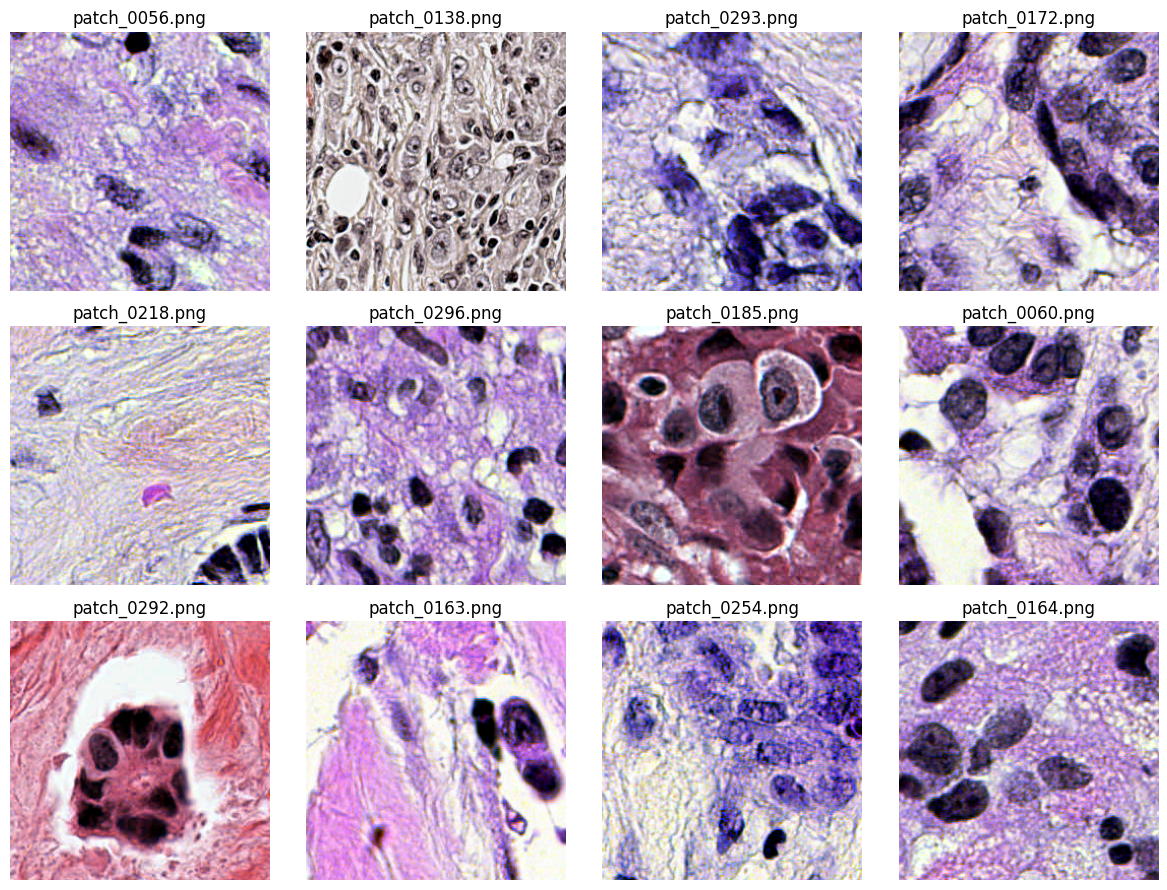

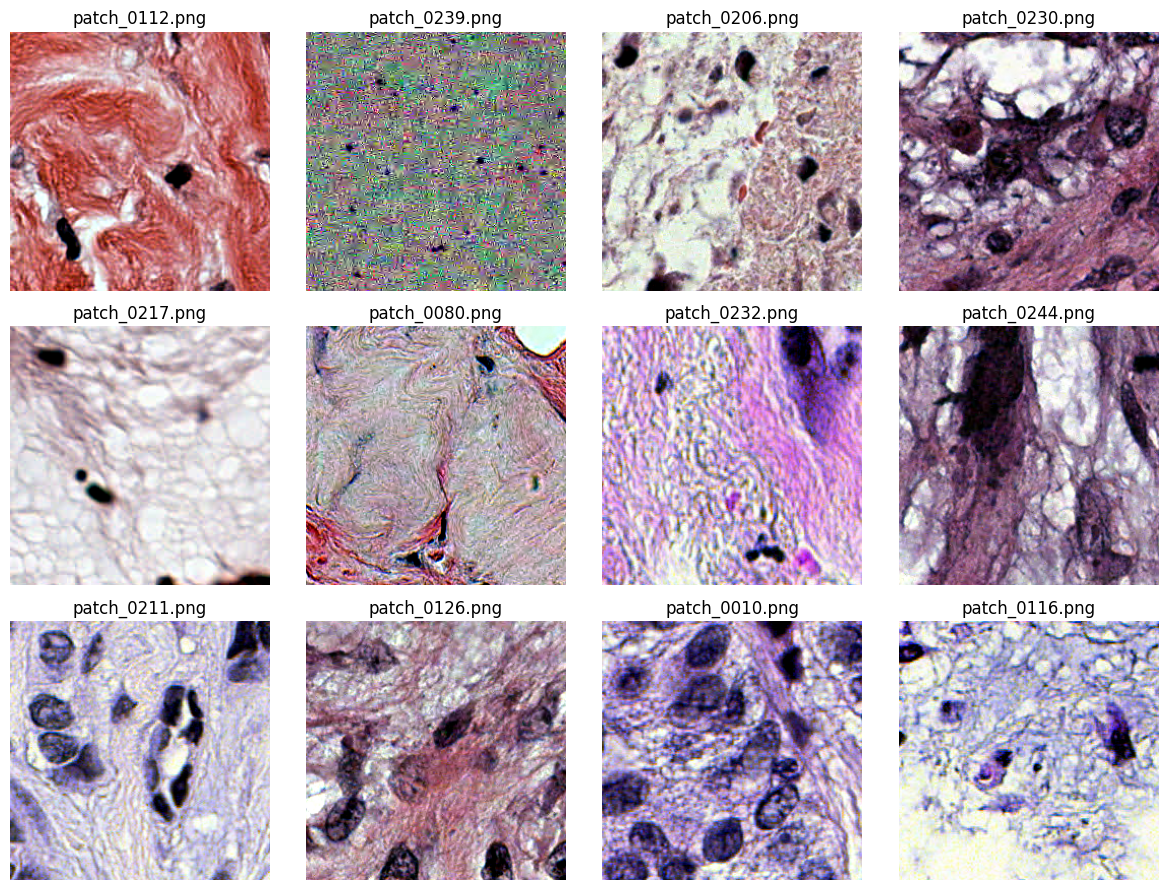

In [ ]:
def show_random_patches(base_dir, class_label, num_patches=12):
    patch_paths = []
    class_path = os.path.join(base_dir, class_label)

    # Traverse all slide folders
    for slide_id in os.listdir(class_path):
        slide_folder = os.path.join(class_path, slide_id)
        if os.path.isdir(slide_folder):
            for fname in os.listdir(slide_folder):
                if fname.endswith(".png"):
                    patch_paths.append(os.path.join(slide_folder, fname))

    # Randomly sample and display
    sample_patches = random.sample(patch_paths, min(num_patches, len(patch_paths)))
    cols = 4
    rows = (len(sample_patches) + cols - 1) // cols
    plt.figure(figsize=(12, 3 * rows))

    for i, patch_path in enumerate(sample_patches):
        patch = Image.open(patch_path)
        plt.subplot(rows, cols, i + 1)
        plt.imshow(patch)
        plt.axis("off")
        plt.title(os.path.basename(patch_path))
    plt.tight_layout()
    plt.show()

# Show random patches from both classes
show_random_patches("/content/drive/MyDrive/IDC_PATCHES_FILTERED", "Yes")
show_random_patches("/content/drive/MyDrive/IDC_PATCHES_FILTERED", "No")


**BAG AUGMENTATION**

In [ ]:
PATCHES_PER_BAG = (200, 300)
BAGS_PER_SLIDE = 7
PATCHES_DIR = "/content/drive/MyDrive/IDC_PATCHES_FILTERED"
BAG_TEMP_DIR = "/content/augmented_bags_temp"

LABELS = ['Yes', 'No']

for label_name in LABELS:
    label_dir = os.path.join(PATCHES_DIR, label_name)
    if not os.path.isdir(label_dir): continue

    for slide_folder in tqdm(os.listdir(label_dir), desc=f"Augmenting {label_name} slides"):
        slide_path = os.path.join(label_dir, slide_folder)
        if not os.path.isdir(slide_path): continue

        patch_paths = [
            os.path.join(slide_path, fname)
            for fname in os.listdir(slide_path)
            if fname.lower().endswith(('.png', '.jpg', '.jpeg'))
        ]

        if len(patch_paths) < 50:
            print(f"⚠️ Skipping slide {slide_folder} — too few patches: {len(patch_paths)}")
            continue

        for i in range(BAGS_PER_SLIDE):
            min_bag, max_bag = PATCHES_PER_BAG
            available = len(patch_paths)

            actual_max = min(available, max_bag)
            actual_min = min(available, min_bag)

            if actual_min == 0:
                bag_patch_count = available
            else:
                bag_patch_count = random.randint(actual_min, actual_max)

            selected_patches = random.sample(patch_paths, bag_patch_count)

            bag_dir = os.path.join(BAG_TEMP_DIR, label_name, slide_folder, f"bag_{i}")
            os.makedirs(bag_dir, exist_ok=True)

            for idx, patch_path in enumerate(selected_patches):
                img = Image.open(patch_path)
                patch_filename = f"{idx:04d}.png"
                img.save(os.path.join(bag_dir, patch_filename))


Augmenting No slides: 100%|██████████| 14/14 [09:55<00:00, 42.53s/it]


In [ ]:
ORIGINAL_PATCHES = "/content/drive/MyDrive/IDC_PATCHES_FILTERED"
TEMP_ORIGINAL_BAGS = "/content/original_bags"

os.makedirs(TEMP_ORIGINAL_BAGS, exist_ok=True)

for label in ["Yes", "No"]:
    label_path = os.path.join(ORIGINAL_PATCHES, label)
    bag_label_path = os.path.join(TEMP_ORIGINAL_BAGS, label)
    os.makedirs(bag_label_path, exist_ok=True)

    for slide in tqdm(os.listdir(label_path), desc=f"Creating original bags for '{label}'"):
        slide_path = os.path.join(label_path, slide)
        if not os.path.isdir(slide_path): continue

        # Create a bag_0 per slide with all patches
        dest_bag = os.path.join(bag_label_path, slide, "bag_0")
        os.makedirs(dest_bag, exist_ok=True)

        for patch_file in os.listdir(slide_path):
            src = os.path.join(slide_path, patch_file)
            dst = os.path.join(dest_bag, patch_file)
            shutil.copy2(src, dst)


Creating original bags for 'No': 100%|██████████| 14/14 [00:19<00:00,  1.42s/it]


In [ ]:
ORIGINAL_BAGS = "/content/original_bags"
AUGMENTED_BAGS = "/content/augmented_bags_temp"
COMBINED_BAGS = "/content/combined_bags"
os.makedirs(COMBINED_BAGS, exist_ok=True)

def copy_bags_with_prefix(src_root, label, prefix):
    src_label_path = os.path.join(src_root, label)
    dst_label_path = os.path.join(COMBINED_BAGS, label)
    os.makedirs(dst_label_path, exist_ok=True)

    for slide in tqdm(os.listdir(src_label_path), desc=f"Copying '{label}' ({prefix})"):
        slide_src = os.path.join(src_label_path, slide)
        if not os.path.isdir(slide_src): continue

        slide_dst = os.path.join(dst_label_path, slide)
        os.makedirs(slide_dst, exist_ok=True)

        for bag_name in os.listdir(slide_src):
            bag_src = os.path.join(slide_src, bag_name)

            # Rename bag
            bag_idx = bag_name.split("_")[-1]
            new_bag_name = f"{prefix}_bag_{bag_idx}"

            bag_dst = os.path.join(slide_dst, new_bag_name)

            if not os.path.exists(bag_dst):
                shutil.copytree(bag_src, bag_dst)

copy_bags_with_prefix(ORIGINAL_BAGS, "Yes", prefix="orig")
copy_bags_with_prefix(ORIGINAL_BAGS, "No", prefix="orig")


copy_bags_with_prefix(AUGMENTED_BAGS, "Yes", prefix="aug")
copy_bags_with_prefix(AUGMENTED_BAGS, "No", prefix="aug")

print("✅ Combined bags structure is ready.")

Copying 'No' (aug): 100%|██████████| 14/14 [00:40<00:00,  2.86s/it]

✅ Combined bags structure is ready.


**RESNET 50 MODEL - FEATURE EXTRACTION**

In [ ]:
model = resnet50(pretrained=True)
model.fc = nn.Identity()  # remove classifier head
model = model.to(device).eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 95.3MB/s]


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [ ]:
def extract_feature(img_path):
    try:
        image = Image.open(img_path).convert("RGB")
        image = transform(image).unsqueeze(0).to(device)
        with torch.no_grad():
            feature = model(image).squeeze().cpu().numpy()
        return feature
    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        return None

In [ ]:
def extract_features_from_bags(bag_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    for label in ["Yes", "No"]:
        label_dir = os.path.join(bag_dir, label)
        if not os.path.isdir(label_dir): continue

        for slide_folder in tqdm(os.listdir(label_dir), desc=f"Processing {label}"):
            slide_path = os.path.join(label_dir, slide_folder)
            if not os.path.isdir(slide_path): continue

            for bag in os.listdir(slide_path):
                bag_path = os.path.join(slide_path, bag)
                if not os.path.isdir(bag_path): continue

                features = []
                for patch in sorted(os.listdir(bag_path)):
                    patch_path = os.path.join(bag_path, patch)
                    feat = extract_feature(patch_path)
                    if feat is not None:
                        features.append(feat)

                features = np.array(features)
                save_name = f"{label}_{slide_folder}_{bag}.npy"
                save_path = os.path.join(output_dir, save_name)
                np.save(save_path, features)

BAG_DIR = "/content/combined_bags"
OUTPUT_FEATURE_DIR = "/content/drive/MyDrive/IDC_FEATURES_RESNET"
extract_features_from_bags(BAG_DIR, OUTPUT_FEATURE_DIR)

Processing No: 100%|██████████| 14/14 [05:58<00:00, 25.60s/it]


**MULTIPLE INSTANCE LEARNING**

In [ ]:
FEATURES_DIR = "/content/drive/MyDrive/IDC_FEATURES_RESNET"
records = []

for fname in os.listdir(FEATURES_DIR):
    if not fname.endswith(".npy"):
        continue

    label = 1 if fname.startswith("Yes_") else 0 if fname.startswith("No_") else None
    if label is None:
        continue

    slide_id = fname.replace(".npy", "")
    feature_path = os.path.join(FEATURES_DIR, fname)

    records.append({
        "slide_id": slide_id,
        "label": label,
        "features_path": feature_path
    })

df = pd.DataFrame(records)
df.to_csv("clam_metadata.csv", index=False)
print("Metadata created:", df.shape)
print(df.head())


Metadata created: (224, 3)
                                            slide_id  label  \
0  Yes_TCGA-AO-A128-01Z-00-DX1.4E6BFFBC-87AD-4ED4...      1   
1  Yes_TCGA-AO-A128-01Z-00-DX1.4E6BFFBC-87AD-4ED4...      1   
2  Yes_TCGA-AO-A128-01Z-00-DX1.4E6BFFBC-87AD-4ED4...      1   
3  Yes_TCGA-AO-A128-01Z-00-DX1.4E6BFFBC-87AD-4ED4...      1   
4  Yes_TCGA-AO-A128-01Z-00-DX1.4E6BFFBC-87AD-4ED4...      1   

                                       features_path  
0  /content/drive/MyDrive/IDC_FEATURES_RESNET/Yes...  
1  /content/drive/MyDrive/IDC_FEATURES_RESNET/Yes...  
2  /content/drive/MyDrive/IDC_FEATURES_RESNET/Yes...  
3  /content/drive/MyDrive/IDC_FEATURES_RESNET/Yes...  
4  /content/drive/MyDrive/IDC_FEATURES_RESNET/Yes...  


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving clam_metadata.csv to clam_metadata.csv


In [ ]:
class ABMIL(nn.Module):
    def __init__(self, in_dim=2048, hidden_dim=64, n_classes=2, dropout=0.5):
        super(ABMIL, self).__init__()
        self.embedding = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.attn = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )
        self.classifier = nn.Linear(hidden_dim, n_classes)

    def forward(self, x):
        h = self.embedding(x)         # [N, hidden_dim]
        A = self.attn(h)              # [N, 1]
        A = torch.softmax(A, dim=0)   # Attention weights
        M = torch.sum(A * h, dim=0)   # Weighted sum
        logits = self.classifier(M)   # Class logits
        return logits, A

In [ ]:
class NPYBagsDataset(Dataset):
    def __init__(self, dataframe):
        self.df = dataframe

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        features = np.load(row['features_path'])
        label = int(row['label'])
        return torch.tensor(features, dtype=torch.float32), label, row['slide_id']


In [ ]:
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss, correct = 0, 0

    for feats, labels, _ in tqdm(loader, leave=False):
        feats = feats.squeeze(0).to(device)
        labels = labels.to(device)

        logits, _ = model(feats)
        loss = criterion(logits.unsqueeze(0), labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (logits.argmax().item() == labels.item())

    return total_loss / len(loader), correct / len(loader)

In [ ]:
def eval_epoch(model, loader):
    model.eval()
    correct = 0
    all_labels, all_preds, all_probs = [], [], []

    with torch.no_grad():
        for feats, labels, _ in loader:
            feats = feats.squeeze(0).to(device)
            labels = labels.to(device)

            logits, _ = model(feats)
            probs = torch.softmax(logits, dim=0)
            pred = probs.argmax().item()

            all_labels.append(labels.item())
            all_preds.append(pred)
            all_probs.append(probs[1].item())

    acc = accuracy_score(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_probs)
    cm = confusion_matrix(all_labels, all_preds)
    return acc, auc, cm

In [ ]:
CSV_PATH = "/content/clam_metadata.csv"
df = pd.read_csv(CSV_PATH)
print("Total bags:", len(df))

Total bags: 224


In [ ]:
df_trainval, df_test = train_test_split(df, test_size=0.15, stratify=df['label'], random_state=42)
df_trainval = df_trainval.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
test_ds = NPYBagsDataset(df_test)
test_loader = DataLoader(test_ds, batch_size=1)

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold = 1

for train_idx, val_idx in skf.split(df_trainval, df_trainval['label']):
    print(f"\n🔁 Fold {fold}")
    train_df = df_trainval.iloc[train_idx].reset_index(drop=True)
    val_df = df_trainval.iloc[val_idx].reset_index(drop=True)

    train_ds = NPYBagsDataset(train_df)
    val_ds = NPYBagsDataset(val_df)

    train_loader = DataLoader(train_ds, batch_size=1, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=1)

    # Initialize model
    model = ABMIL(in_dim=2048).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

    best_auc = 0
    patience = 5
    counter = 0
    EPOCHS = 30

    print(f"{'Epoch':>5} | {'TrLoss':>7} | {'TrAcc':>6} | {'ValAcc':>6} | {'AUC':>6}")
    print("-" * 36)

    for epoch in range(1, EPOCHS + 1):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
        val_acc, val_auc, cm = eval_epoch(model, val_loader)

        print(f"{epoch:5d} | {train_loss:7.4f} | {train_acc:6.4f} | {val_acc:6.4f} | {val_auc:6.4f}")

        if val_auc > best_auc:
            best_auc = val_auc
            counter = 0
            torch.save(model.state_dict(), f"best_abmil_fold{fold}.pth")
        else:
            counter += 1
            if counter >= patience:
                print("⏹ Early stopping.")
                break

    fold += 1


🔁 Fold 1
Epoch |  TrLoss |  TrAcc | ValAcc |    AUC
------------------------------------


    1 |  0.6926 | 0.5526 | 0.5000 | 0.6039


    2 |  0.6680 | 0.6053 | 0.7368 | 0.8366


    3 |  0.6398 | 0.6579 | 0.6842 | 0.7895


    4 |  0.6242 | 0.6316 | 0.6842 | 0.8199


    5 |  0.6039 | 0.6579 | 0.7632 | 0.9058


    6 |  0.5337 | 0.7566 | 0.5526 | 0.9280


    7 |  0.4800 | 0.7829 | 0.7368 | 0.9668


    8 |  0.4605 | 0.7763 | 0.9474 | 0.9834


    9 |  0.3422 | 0.8684 | 0.9737 | 0.9917


   10 |  0.2468 | 0.8947 | 0.9737 | 1.0000


   11 |  0.1900 | 0.9474 | 0.9737 | 1.0000


   12 |  0.1276 | 0.9803 | 0.9737 | 1.0000


   13 |  0.1104 | 0.9605 | 1.0000 | 1.0000


   14 |  0.0722 | 0.9934 | 0.9737 | 1.0000


   15 |  0.0714 | 0.9868 | 0.9737 | 1.0000
⏹ Early stopping.

🔁 Fold 2
Epoch |  TrLoss |  TrAcc | ValAcc |    AUC
------------------------------------


    1 |  0.7065 | 0.4934 | 0.5000 | 0.6953


    2 |  0.6779 | 0.5658 | 0.5526 | 0.7147


    3 |  0.6528 | 0.6118 | 0.6579 | 0.7562


    4 |  0.6252 | 0.6711 | 0.6579 | 0.7895


    5 |  0.5850 | 0.7237 | 0.7105 | 0.8532


    6 |  0.5501 | 0.7105 | 0.7895 | 0.8809


    7 |  0.5368 | 0.7368 | 0.7895 | 0.9169


    8 |  0.4694 | 0.8026 | 0.8421 | 0.9335


    9 |  0.4018 | 0.8421 | 0.8684 | 0.9834


   10 |  0.3271 | 0.8816 | 0.9211 | 1.0000


   11 |  0.2540 | 0.9013 | 1.0000 | 1.0000


   12 |  0.1919 | 0.9408 | 1.0000 | 1.0000


   13 |  0.1209 | 0.9737 | 0.9737 | 1.0000


   14 |  0.1137 | 0.9737 | 1.0000 | 1.0000


   15 |  0.0812 | 0.9868 | 1.0000 | 1.0000
⏹ Early stopping.

🔁 Fold 3
Epoch |  TrLoss |  TrAcc | ValAcc |    AUC
------------------------------------


    1 |  0.7048 | 0.5132 | 0.5789 | 0.6537


    2 |  0.6777 | 0.5921 | 0.6316 | 0.7368


    3 |  0.6374 | 0.6118 | 0.6579 | 0.7452


    4 |  0.6076 | 0.6842 | 0.5789 | 0.7784


    5 |  0.5886 | 0.6711 | 0.6316 | 0.7784


    6 |  0.5314 | 0.7368 | 0.6842 | 0.8033


    7 |  0.4791 | 0.8026 | 0.7105 | 0.8532


    8 |  0.4263 | 0.8421 | 0.8421 | 0.9335


    9 |  0.3189 | 0.8684 | 0.9474 | 0.9945


   10 |  0.2567 | 0.9276 | 0.9474 | 0.9945


   11 |  0.2061 | 0.9474 | 0.9474 | 1.0000


   12 |  0.1652 | 0.9474 | 1.0000 | 1.0000


   13 |  0.1076 | 0.9868 | 1.0000 | 1.0000


   14 |  0.0727 | 0.9868 | 1.0000 | 1.0000


   15 |  0.0720 | 0.9868 | 1.0000 | 1.0000


   16 |  0.0473 | 0.9934 | 1.0000 | 1.0000
⏹ Early stopping.

🔁 Fold 4
Epoch |  TrLoss |  TrAcc | ValAcc |    AUC
------------------------------------


    1 |  0.6886 | 0.5461 | 0.6316 | 0.7895


    2 |  0.6557 | 0.6184 | 0.7105 | 0.8310


    3 |  0.6230 | 0.6250 | 0.6316 | 0.9030


    4 |  0.5911 | 0.7039 | 0.7632 | 0.9086


    5 |  0.5242 | 0.7303 | 0.8421 | 0.9169


    6 |  0.4517 | 0.8158 | 0.7632 | 0.9252


    7 |  0.3756 | 0.8224 | 0.8421 | 1.0000


    8 |  0.2913 | 0.8618 | 0.8684 | 1.0000


    9 |  0.2255 | 0.9079 | 1.0000 | 1.0000


   10 |  0.1371 | 0.9737 | 1.0000 | 1.0000


   11 |  0.1119 | 0.9803 | 1.0000 | 1.0000


   12 |  0.0844 | 0.9803 | 1.0000 | 1.0000
⏹ Early stopping.

🔁 Fold 5
Epoch |  TrLoss |  TrAcc | ValAcc |    AUC
------------------------------------


    1 |  0.7025 | 0.5461 | 0.5263 | 0.6704


    2 |  0.6742 | 0.6053 | 0.5263 | 0.6731


    3 |  0.6410 | 0.6711 | 0.5263 | 0.6814


    4 |  0.5980 | 0.6908 | 0.6842 | 0.7091


    5 |  0.5627 | 0.6908 | 0.7368 | 0.7396


    6 |  0.5289 | 0.7434 | 0.6316 | 0.7701


    7 |  0.4681 | 0.7895 | 0.7895 | 0.8199


    8 |  0.3931 | 0.8421 | 0.7105 | 0.8338


    9 |  0.3328 | 0.8816 | 0.7632 | 0.8920


   10 |  0.2154 | 0.9276 | 0.9211 | 0.9363


   11 |  0.1493 | 0.9539 | 0.9211 | 0.9501


   12 |  0.1253 | 0.9737 | 0.8947 | 0.9640


   13 |  0.0993 | 0.9803 | 0.9737 | 0.9640


   14 |  0.0657 | 1.0000 | 0.9737 | 0.9640


   15 |  0.0780 | 0.9671 | 0.9737 | 0.9612


   16 |  0.0483 | 0.9934 | 0.9737 | 0.9668


   17 |  0.0357 | 1.0000 | 0.9737 | 0.9668


   18 |  0.0271 | 1.0000 | 0.9737 | 0.9612


   19 |  0.0260 | 1.0000 | 0.9737 | 0.9668


   20 |  0.0221 | 0.9934 | 0.9737 | 0.9668


   21 |  0.0273 | 0.9934 | 0.9737 | 0.9668
⏹ Early stopping.


In [ ]:
print("\n📊 Final Evaluation on Hold-Out Test Set")
model.load_state_dict(torch.load(f"best_abmil_fold5.pth"))
model.eval()
test_acc, test_auc, test_cm = eval_epoch(model, test_loader)
print(f"Test Accuracy: {test_acc:.4f} | Test AUC: {test_auc:.4f}")
print("Test Confusion Matrix:\n", test_cm)



📊 Final Evaluation on Hold-Out Test Set
Test Accuracy: 0.9412 | Test AUC: 0.9965
Test Confusion Matrix:
 [[15  2]
 [ 0 17]]


In [ ]:
MODEL_SAVE_PATH = "/content/drive/MyDrive/abmil_idc_model.pth"
torch.save(model.state_dict(), MODEL_SAVE_PATH)
print(f"✅ Model saved to {MODEL_SAVE_PATH}")

✅ Model saved to /content/drive/MyDrive/abmil_idc_model.pth


In [ ]:
model = ABMIL().to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/abmil_idc_model.pth"))
model.eval()

ABMIL(
  (embedding): Sequential(
    (0): Linear(in_features=2048, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
  )
  (attn): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)

In [ ]:
test_acc, test_auc, test_cm = eval_epoch(model, test_loader)
print(f"Test Accuracy: {test_acc:.4f} | Test AUC: {test_auc:.4f}")

Test Accuracy: 0.9412 | Test AUC: 0.9965


/tmp/ipython-input-37-1969286234.py:10: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


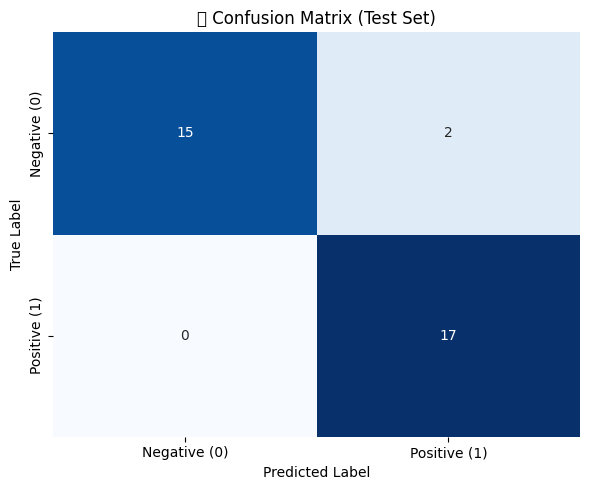

In [ ]:
labels = ['Negative (0)', 'Positive (1)']

plt.figure(figsize=(6, 5))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels, cbar=False)

plt.title('📊 Confusion Matrix (Test Set)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

/tmp/ipython-input-58-3625456561.py:27: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


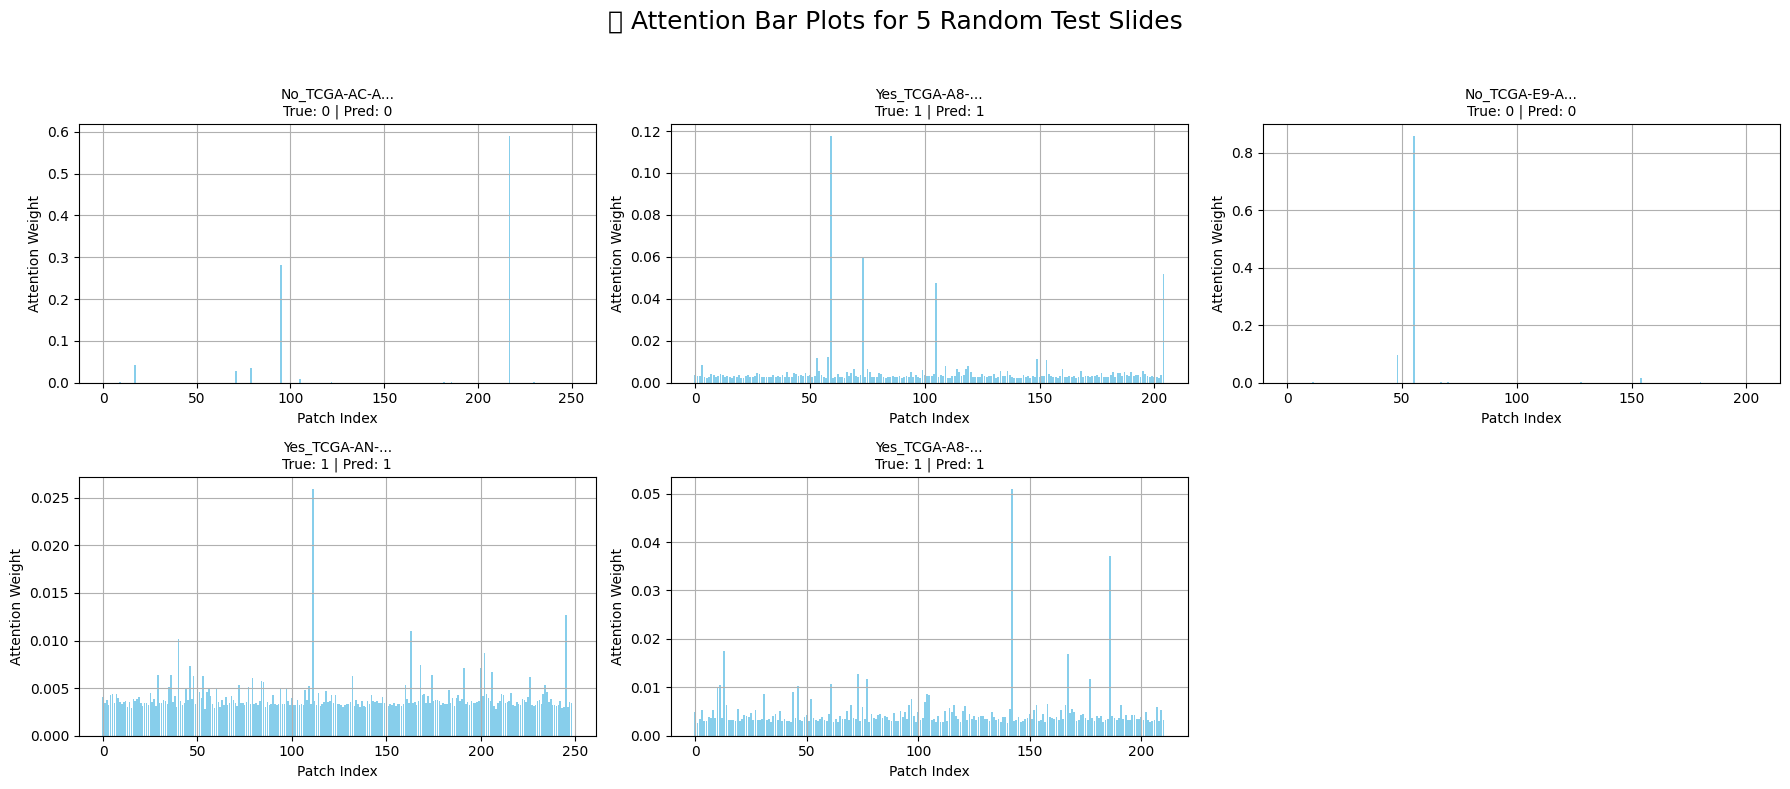

In [ ]:
model.eval()

# Pick 5 random test slides
random_indices = random.sample(range(len(test_ds)), 5)

fig, axes = plt.subplots(2, 3, figsize=(18, 8))
fig.suptitle("🎯 Attention Bar Plots for 5 Random Test Slides", fontsize=18)

axes = axes.flatten()

# Plot each attention distribution
for i, idx in enumerate(random_indices):
    features, label, slide_id = test_ds[idx]
    logits, attn_weights = model(features.to(device))
    attn_scores = attn_weights.squeeze().detach().cpu().numpy()
    pred = logits.argmax().item()

    ax = axes[i]
    ax.bar(np.arange(len(attn_scores)), attn_scores, color='skyblue')
    ax.set_title(f"{slide_id[:12]}...\nTrue: {label} | Pred: {pred}", fontsize=10)
    ax.set_xlabel("Patch Index")
    ax.set_ylabel("Attention Weight")
    ax.grid(True)

axes[-1].axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

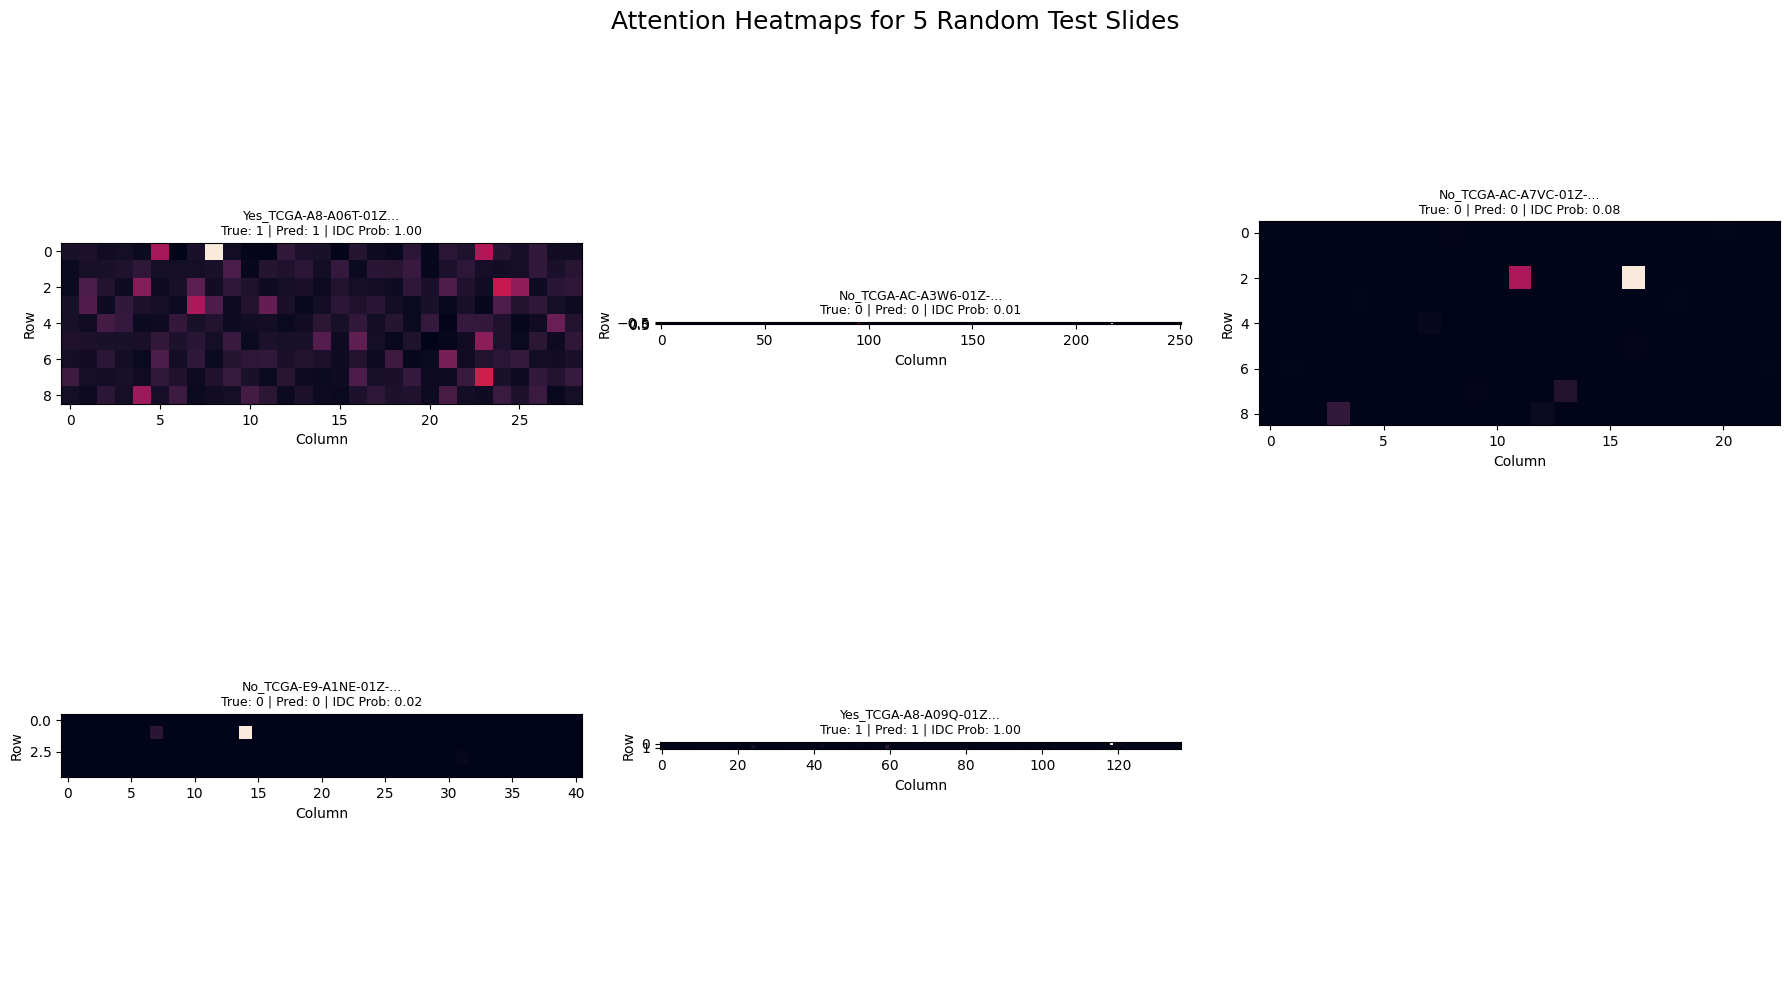

In [ ]:
model.eval()

def infer_grid_shape(n):
    side = int(np.floor(np.sqrt(n)))
    for i in range(side, 0, -1):
        if n % i == 0:
            return (i, n // i)
    return (1, n)

random_indices = random.sample(range(len(test_ds)), 5)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle("Attention Heatmaps for 5 Random Test Slides", fontsize=18)

axes = axes.flatten()

# Plot 5 attention heatmaps
for i, idx in enumerate(random_indices):
    features, label, slide_id = test_ds[idx]
    logits, attn_weights = model(features.to(device))
    pred = logits.argmax().item()
    prob = torch.softmax(logits, dim=0)[1].item()

    attn_scores = attn_weights.squeeze().detach().cpu().numpy()
    grid_shape = infer_grid_shape(len(attn_scores))
    attn_grid = attn_scores.reshape(grid_shape)

    im = axes[i].imshow(attn_grid, cmap='rocket', interpolation='nearest')
    axes[i].set_title(
        f"{slide_id[:20]}...\nTrue: {label} | Pred: {pred} | IDC Prob: {prob:.2f}",
        fontsize=9
    )
    axes[i].set_xlabel("Column")
    axes[i].set_ylabel("Row")

axes[-1].axis("off")



plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()